In [9]:
from crocoddyl import *
import pinocchio as pin
import numpy as np
from crocoddyl.diagnostic import displayTrajectory

In [10]:
# LOAD ROBOT
robot = loadHector()
robot.initViewer(loadModel=True)
robot.display(robot.q0)

robot.framesForwardKinematics(robot.q0)

rmodel = robot.model

In [17]:
def uavPlacementModel(targetPos, targetQuat, integrationStep, frameName):
    # ACTUATION MODEL
    distanceRotorCOG = 0.1525
    cf = 6.6e-5
    cm = 1e-6
    actModel = ActuationModelUAM(robot.model, '+', distanceRotorCOG, cf, cm)

    # COST MODEL
    # Create a cost model per the running and terminal action model.
    runningCostModel = CostModelSum(rmodel, actModel.nu)
    terminalCostModel = CostModelSum(rmodel, actModel.nu)

    state = StatePinocchio(rmodel)
    SE3ref = pin.SE3()
    SE3ref.translation = targetPos.reshape(3,1)
    SE3ref.rotation = targetQuat.matrix()

    wBasePos  = [0.1]
    wBaseOri  = [1000]
    wBaseVel  = [1000]
    wBaseRate = [10]
    
    stateWeights   = np.array(wBasePos * 3 + wBaseOri * 3 + wBaseVel * robot.model.nv)
    controlWeights = np.array([1]*4)
    
    goalTrackingCost = CostModelFramePlacement(rmodel,
                                               frame=rmodel.getFrameId(frameName),
                                               ref=SE3ref,
                                               nu=actModel.nu)
    goalFrameVelocity = CostModelFrameVelocity(rmodel,
                                              frame=rmodel.getFrameId(frameName))
    
    xRegCost = CostModelState(rmodel, 
                              state, 
                              ref=state.zero(), 
                              nu=actModel.nu,
                              activation=ActivationModelWeightedQuad(stateWeights))
    uRegCost = CostModelControl(rmodel, 
                                nu=robot.
                                model.nv-2,
                                activation = ActivationModelWeightedQuad(controlWeights))
    uLimCost = CostModelControl(rmodel, 
                                nu=robot.
                                model.nv-2,
                                activation = ActivationModelInequality(np.array([0.1, 0.1, 0.1, 0.1]), 
                                                                    np.array([5, 5, 5, 5])))

    # Then let's add the running and terminal cost functions
    runningCostModel.addCost(name="pos", weight=0.01, cost=goalTrackingCost)
    runningCostModel.addCost(name="regx", weight=1e-6, cost=xRegCost)
    runningCostModel.addCost(name="regu", weight=1e-6, cost=uRegCost)
    runningCostModel.addCost(name="limu", weight=1e-4, cost=uLimCost)
    terminalCostModel.addCost(name="pos", weight=100, cost=goalTrackingCost)
    # terminalCostModel.addCost(name="vel", weight=10, cost=goalFrameVelocity)

    # DIFFERENTIAL ACTION MODEL
    runningDmodel  = DifferentialActionModelActuated(rmodel, actModel, runningCostModel)
    terminalDmodel = DifferentialActionModelActuated(rmodel, actModel, terminalCostModel)
    runningModel = IntegratedActionModelEuler(runningDmodel)
    runningModel.timeStep =  integrationStep  
    terminalModel = IntegratedActionModelEuler(terminalDmodel)
    terminalModel.timeStep =  integrationStep  
    
    return runningModel,terminalModel   

In [18]:
# DEFINING THE SHOOTING PROBLEM & SOLVING

dt = 3e-2
T = 33

# DEFINE POSITION WAYPOINTS
target_pos = [np.array([0,0,1])]
target_pos += [np.array([0,1,1])]
quat = pin.Quaternion(1, 0, 0, 0)
quat.normalize()
target_quat = [quat]*2

# Plot goal frame
for i in range(0,len(target_pos)):
    robot.viewer.gui.addXYZaxis('world/wp%i' % i, [1., 0., 0., 1.], .03, 0.5)
    robot.viewer.gui.applyConfiguration('world/wp%i' % i, 
                                        target_pos[i].tolist() + [target_quat[i][0], target_quat[i][1], target_quat[i][2], target_quat[i][3]])
    
robot.viewer.gui.refresh()

In [19]:
models = []
# len(target_pos)
for i in range(1, 2):
    runningModel, terminalModel = uavPlacementModel(target_pos[i], target_quat[i], dt, 'base_link')
    models += [runningModel]*(T-1) + [terminalModel]

    
# From ground to 1st waypoint
q0 = robot.q0
x0 = np.hstack([m2a(q0), np.zeros(robot.model.nv)])

problem = ShootingProblem(x0, models[:-1], models[-1])

# Creating the DDP solver for this OC problem, defining a logger
ddp = SolverFDDP(problem)
ddp.callback = [CallbackDDPVerbose()]
ddp.callback.append(CallbackDDPLogger())

# From 1st waypoint to 2nd waypoint
# x0 = np.array([ 3.64921977e-11, -2.33702527e-10,  9.99972616e-01,  7.55260190e-13, 
#               1.18488377e-13,  5.00281541e-18,  1.00000000e+00,  7.78469510e-08,
#                -4.97668391e-07, -4.04832071e-01,  1.15972591e-06,  1.81076620e-07, -9.47254507e-15])

us0 = [m.differential.quasiStatic(d.differential, problem.initialState)
       for m, d in zip(ddp.problem.runningModels, ddp.problem.runningDatas)]

xs0 = [problem.initialState]
N = len(problem.runningModels)
x_goal  = target_pos[1]
x_start = problem.initialState
for i in range(0, N):
    alpha = float(i)/float(N) 
    x_curr = x_start[:3] + alpha*(x_goal - x_start[:3])
    x_curr = np.append(x_curr, np.array([0,0,0,1] + [0]*rmodel.nv))
    xs0 = xs0 + [x_curr]

In [20]:
ddp.solve(init_xs=xs0, init_us=us0, maxiter=150)
#ddp.solve(init_xs=xs0, maxiter=150)

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  2.19793e-01  2.82170e-03  5.13687e+00  1.00000e-08  1.00000e-08   0.0020     0
   1  2.19793e-01  2.82204e-03  5.13714e+00  1.00000e-07  1.00000e-07   0.0020     0
   2  2.19793e-01  2.82540e-03  5.13980e+00  1.00000e-06  1.00000e-06   0.0020     0
   3  1.82700e-01  2.85885e-03  2.80245e+00  1.00000e-06  1.00000e-06   0.5000     0
   4  1.72132e-01  6.98676e-04  6.86336e-01  1.00000e-06  1.00000e-06   0.5000     0
   5  1.99085e-01  1.45051e-04  2.65010e-02  1.00000e-07  1.00000e-07   1.0000     1
   6  1.97153e-01  2.93350e-06  8.42567e-03  1.00000e-07  1.00000e-07   0.5000     1
   7  1.94673e-01  1.87375e-06  4.48305e-03  1.00000e-08  1.00000e-08   1.0000     1
   8  1.93497e-01  2.13372e-06  5.24922e-03  1.00000e-08  1.00000e-08   0.5000     1
   9  1.92935e-01  1.35144e-06  3.16197e-03  1.00000e-09  1.00000e-09   1.0000     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
  10  1.91723e

([array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([-3.06865942e-08,  3.44297617e-04,  8.39738253e-03, -4.09661670e-02,
         -1.24107082e-05, -3.20571572e-04,  9.99160483e-01,  0.00000000e+00,
          0.00000000e+00,  2.80226343e-01, -2.73184232e+00, -8.27612159e-04,
         -2.13774207e-02]),
  array([-6.02108757e-08,  2.48181051e-03,  2.59832153e-02, -7.79900946e-02,
         -1.28827741e-05, -2.89230440e-04,  9.96954092e-01, -8.07108996e-06,
          1.12641502e-03,  5.90643055e-01, -2.47278245e+00, -9.10328535e-04,
          2.07031922e-03]),
  array([ 1.58799534e-07,  7.48579971e-03,  5.24273913e-02, -1.05324132e-01,
         -1.66602459e-05, -2.56181547e-04,  9.94437912e-01, -1.27075709e-05,
          3.07560724e-03,  8.97222753e-01, -1.83003091e+00, -9.52233146e-04,
          2.15213739e-03]),
  array([ 6.89257766e-07,  1.60338019e-02,  8.70069179e-02, -1.23478781e-01,
         -1.94921206e-05, -2.25819634e-04,  9.92347187e-01, -1.25113810e-05,
      

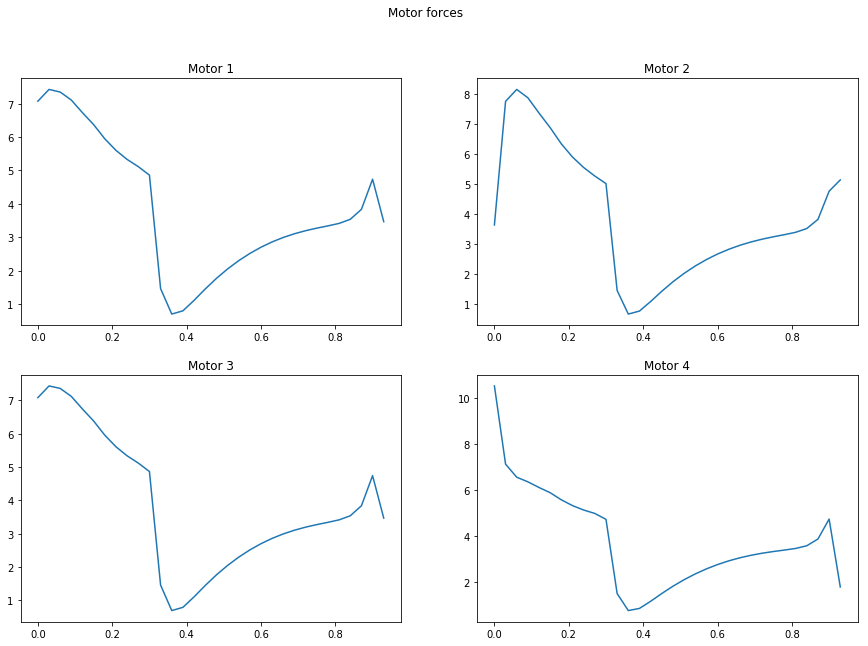

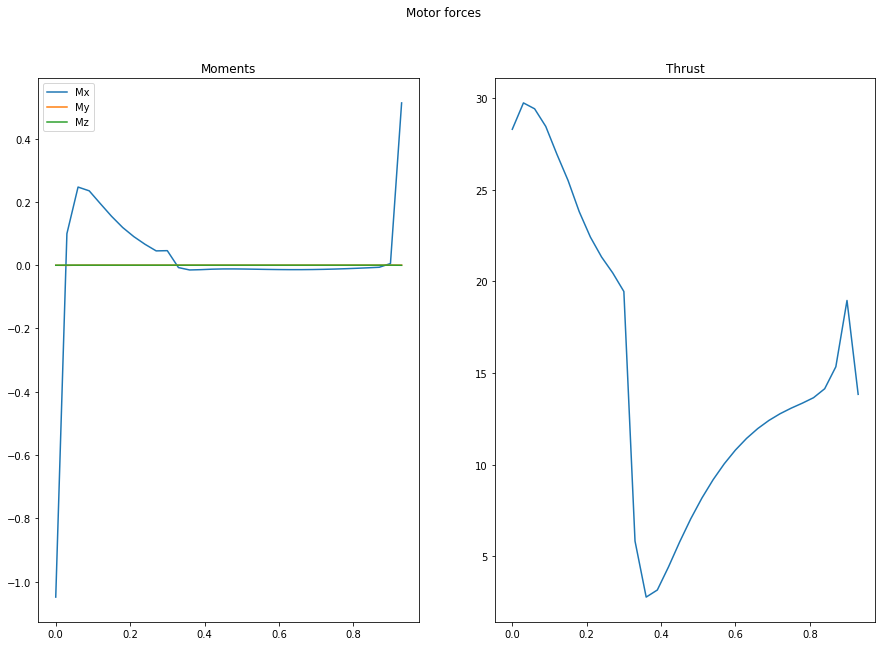

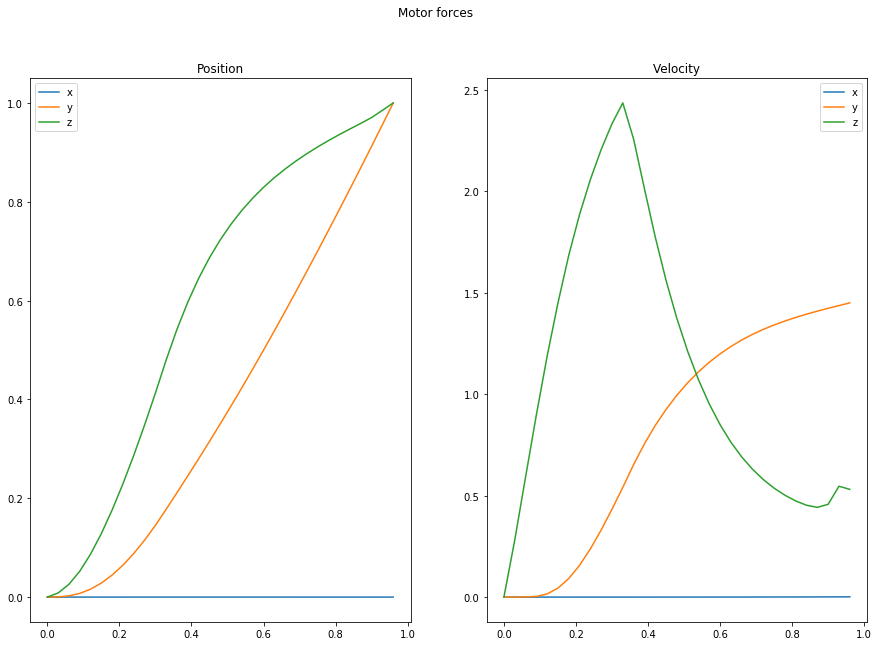

In [21]:
distanceRotorCOG = 0.1525
cf = 6.6e-5
cm = 1e-6
pltUAM = PlotUAM('+', ddp.xs, ddp.us, np.size(ddp.us,0), dt, distanceRotorCOG, cf, cm)

pltUAM.plotMotorForces();
pltUAM.plotFlyingPlatformActuation();
pltUAM.plotFlyingPlatformState();

In [23]:
displayTrajectory(robot, ddp.xs, dt)

In [35]:
u = np.array([1,2,3,4])

uLim, lLim = 5, 0.1
range = uLim - lLim
f = lLim + range/2 + range/2*np.tanh(u)
v = np.tanh(u)
d_v = np.tanh(u)**2
J_f_u = np.zeros([4,4])
np.fill_diagonal(J_f_u, d_v)
print J_f_u, d_v

 [[0.58002566 0.         0.         0.        ]
 [0.         0.92934918 0.         0.        ]
 [0.         0.         0.99013396 0.        ]
 [0.         0.         0.         0.99865905]] [0.58002566 0.92934918 0.99013396 0.99865905]
